# Prostate cANcer graDe Assessment (PANDA) Challenge: Creating the Training Dataset

# Introduction

## Prostate Gland and Prostate Cancer

The prostate is part of the male reproductive system.  The function of the prostate gland is to secrete substances to the urethra.  These secretions nurish and transport sperm.  Prostate cancer is diagnosed from samples from a prostate biopsy (rmicrobe).  The sample is first assigned as a gleason score.  This score is converted to a ISUP grade of 0-5.  The score of 0 is negative and the score of 5 is the most severe form of cancer (Prostate cANcer GraDe Assessment (PANDA) Challenge).

The purpose of this notebook is to use fast.ai and ResNet34 to predict the ISUP grade of different prostate cancer biopsies.

## Current Problems With Image Processing and Training

<font color='red'>Problem 1:</font> The biopsy has a large size and it is difficult to observe the glands in the biopsy.

<font color='green'>Solution 1:</font> Randomly generate patches of the biopsy to magnify the stroma of the prostate.

<font color='red'>Problem 2:</font> The randomly generated patches may only show blank areas and the prostate capsule.

<font color='green'>Solution 2:</font> Remove gray areas around the biopsy and generate patches that are generated from areas that have a minimal amount of white area.  This increases the probability that the patches will be in the prostate stroma.

<font color='red'>Problem 3:</font> Despite removing suspicious slides, there are slides with blue ink and slides that appear to be stained improperly.  Some images may also be difficult to discern because of the glandular pattern or the patch generation.

<font color='green'>Solution 3:</font> Removing high error biopsy slides would ensure that the training images are appropriate for creating a training model.

## Image Processing and Creating the Dataset 

1. Remove the gray area surrounding the biopsy.  The first step involves removing the gray area from around the biopsy (Zenify). 
2. Create 4X4 patched image.  The second step is to take 16 samples that have the lowest portion of white.  This ensures that the sample is most likely going to show the appropriate part of the sample (i.e. glands). (PAB97).
3. Use fast.ai and ResNet34 to train and predict ISUP grades.
4. Remove High Error Biopsies.  Remove biopsies with a high error difference.  The error difference will be at least two ISUP grades higher than the assigned ISUP.
5. Use fast.ai and ResNet34 to train and predict ISUP grades.
6. Remove High Error Biopsies.  Remove biopsies with a high error difference.  The error difference will be at least two ISUP grades higher than the assigned ISUP.
7. This will be the dataset for training.

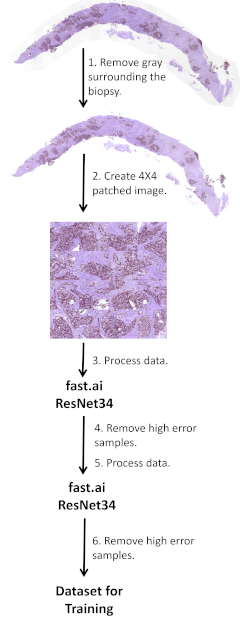

# Import fast.ai and Dependencies

## Install fastai without Internet

Internet is not allowed in this competition.  The files have to be loaded through the fastai2 dataset.

In [ ]:
!pip install ../input/fastai2/fastprogress-0.2.3-py3-none-any.whl
!pip install ../input/fastai2/fastcore-0.1.18-py3-none-any.whl
!pip install ../input/fastai2/fastai2-0.0.17-py3-none-any.whl

## Import fast.ai

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

## Load Dependencies

In [ ]:
import os
import cv2
import PIL
from PIL import Image as Img
from PIL import ImageTk
import random
import openslide
import skimage.io
import skimage.color
from skimage.color import rgb2hsv
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Set Random Seed

Setting a random seed makes sure that all randomly picked sequences are in the same order.  It is important to keep the same seed everytime to keep the same sequence everytime.

In [ ]:
np.random.seed(2)

# Import the Prostate Cancer Grade Assessment Dataframe

Import the PANDAS .csv file from the PANDAS directory.  This will be the PANDAS dataframe.  The other file came from [panda-analysis](http://https://www.kaggle.com/dannellyz/panda-analysis).  This database included suspicious slides that either had no masks or marking on them.

In [ ]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv', index_col=False)

suspicious_slides = pd.read_csv('../input/panda-analysis/PANDA_Suspicious_Slides.csv', index_col=False)

data_dir = '../input/prostate-cancer-grade-assessment/train_images/'

It is important to get a preview of the suspicious_slides and the train_df dataframes.

In [ ]:
suspicious_slides.head()

In [ ]:
train_df.head()

Some suspicious slides filenames have been removed from train.csv.  These rows must be removed from the suspicious_slides dataframe before removing the suspicious slides from train.csv.  If they are not removed, an error will occur.

In [ ]:
suspicious_slides = suspicious_slides.set_index('image_id')

suspicious_slides.drop (['01dfcde514052a6dc35ea4407f41d6e1'], inplace = True)

suspicious_slides.drop (['501403e5c13c7b86bc9312d087a6e490'], inplace = True)

suspicious_slides.drop (['8be88cbd606502cf980f721d57c1c794'], inplace = True)

suspicious_slides.drop (['9665b32251dfc1c438787d36e8b66dd0'], inplace = True)

suspicious_slides.drop (['c0852776d3142ce132a90c6142bd7146'], inplace = True)

suspicious_slides.drop (['cdb7663719497428b4d9243b76da3ace'], inplace = True)

suspicious_slides.drop (['d6b1c8ca6037b5ddca5d2086975a643b'], inplace = True)

suspicious_slides.drop (['3790f55cad63053e956fb73027179707'], inplace = True)

suspicious_slides.drop (['4a2ca53f240932e46eaf8959cb3f490a'], inplace = True)

suspicious_slides.drop (['e4215cfc8c41ec04a55431cc413688a9'], inplace = True)

suspicious_slides.drop (['aaa5732cd49bffddf0d2b7d36fbb0a83'], inplace = True)

suspicious_slides = suspicious_slides.reset_index()

Delete the suspicous slides before the analysis.

In [ ]:
suspicious = list (suspicious_slides['image_id'])

train_df = train_df.set_index('image_id')

for i in suspicious:
    train_df.drop([i], inplace=True)

# Exploratory Data Analysis of the PANDAS Dataframe

It is important to get basic statistics on the PANDAS dataframe to understand the distribution of the data and to make sure the data is labeled properly.

In [ ]:
train_df.head ()

In [ ]:
train_df = train_df.reset_index()

train_df.head()

**Get the number of IDs (biopsy samples) for the dataframe.**

In [ ]:
print("Number of IDs: ", len(train_df.image_id.unique()))

**Make sure the Data Providers and ISUP Grades are labeled properly for the dataframe.**

In [ ]:
print("Number of Data Providers: ", len(train_df.data_provider.unique()))
print("Number of ISUP Grades: ", len(train_df.isup_grade.unique()))

**Make sure the Gleason Scores are labeled properly for the dataframe and has the proper ISUP Grade label.**

In [ ]:
print("Number of Gleason Scores: ", len(train_df.gleason_score.unique()))

In [ ]:
train_df['gleason_score'].unique()

Check the negative labels of the dataframe and make sure it has the proper ISUP Grade label.

In [ ]:
print(train_df[train_df['gleason_score']=='0+0']['isup_grade'].unique())
print(train_df[train_df['gleason_score']=='negative']['isup_grade'].unique())

Check to make sure the 3+4, 4+3, 3+5, 5+3, 5+4, and 4+5 gleason score are labeled properly and make sure it has the proper ISUP Grade label.

In [ ]:
print(train_df[(train_df['gleason_score']=='3+4') | (train_df['gleason_score']=='4+3')]['isup_grade'].unique())
print(train_df[(train_df['gleason_score']=='3+5') | (train_df['gleason_score']=='5+3')]['isup_grade'].unique())
print(train_df[(train_df['gleason_score']=='5+4') | (train_df['gleason_score']=='4+5')]['isup_grade'].unique())

Check to see if the Gleason Score 3+4 or 4+3 may have the improper ISUP Grade label.

In [ ]:
print(train_df[train_df['gleason_score']=='3+4']['isup_grade'].unique())
print(train_df[train_df['gleason_score']=='4+3']['isup_grade'].unique())

Find the mislabeled sample for 4+3 and get rid of the ID.

In [ ]:
train_df[(train_df['isup_grade'] == 2) & (train_df['gleason_score'] == '4+3')]

In [ ]:
train_df.drop([6852],inplace=True)

**Recheck the numbers.**

In [ ]:
print("Number of IDs: ", len(train_df.image_id.unique()))
print("Number of Data Providers: ", len(train_df.data_provider.unique()))
print("Number of ISUP Grades: ", len(train_df.isup_grade.unique()))
print("Number of Gleason Scores: ", len(train_df.gleason_score.unique()))

# Import the Prostate Train Dataframe

Import the four .csv file from the prostate train dataset directory. This will be the training dataframe for this part of the process.  The code will be commented out of for this version of the notebook.  To use this code, comment out the code under the **Import the Prostate Cancer Grade Assessment Dataframe** and **Exploratory Data Analysis of the PANDAS Dataframe**.

In [ ]:
#train_df1 = pd.read_csv('../input/prostate-train-dataset/prediction_df1.csv', index_col=False)

#train_df2 = pd.read_csv('../input/prostate-train-dataset/prediction_df2.csv', index_col=False)

#train_df3 = pd.read_csv('../input/prostate-train-dataset/prediction_df3.csv', index_col=False)

#train_df4 = pd.read_csv('../input/prostate-train-dataset/prediction_df4.csv', index_col=False)

#data_dir = '../input/prostate-cancer-grade-assessment/train_images/'

Append the four dataframes and get rid of the 'Unnamed:0' column.

In [ ]:
#train_df = train_df1.append(train_df2, ignore_index=True)
#train_df = train_df.append(train_df3, ignore_index=True)
#train_df = train_df.append(train_df4, ignore_index=True)

In [ ]:
#train_df = train_df.drop(columns=['Unnamed: 0'])

Get a preview of the dataframe.

In [ ]:
#train_df.head ()

Reset the index to the dataframe.

In [ ]:
#train_df = train_df.reset_index()

#train_df.head()

It is important to get basic statistics on the PANDAS dataframe to understand the distribution of the data and to make sure the data is labeled properly.

**Get the number of IDs (biopsy samples) for the dataframe.**

In [ ]:
#print("Number of IDs: ", len(train_df.image_id.unique()))

**Make sure the Data Providers and ISUP Grades are labeled properly for the dataframe.**

In [ ]:
#print("Number of Data Providers: ", len(train_df.data_provider.unique()))
#print("Number of ISUP Grades: ", len(train_df.isup_grade.unique()))

**Make sure the Gleason Scores are labeled properly for the dataframe and has the proper ISUP Grade label.**

In [ ]:
#print("Number of Gleason Scores: ", len(train_df.gleason_score.unique()))

In [ ]:
#train_df['gleason_score'].unique()

Check the negative labels of the dataframe and make sure it has the proper ISUP Grade label.

In [ ]:
#print(train_df[train_df['gleason_score']=='0+0']['isup_grade'].unique())
#print(train_df[train_df['gleason_score']=='negative']['isup_grade'].unique())

Check to make sure the 3+4, 4+3, 3+5, 5+3, 5+4, and 4+5 gleason score are labeled properly and make sure it has the proper ISUP Grade label.

In [ ]:
#print(train_df[(train_df['gleason_score']=='3+4') | (train_df['gleason_score']=='4+3')]['isup_grade'].unique())
#print(train_df[(train_df['gleason_score']=='3+5') | (train_df['gleason_score']=='5+3')]['isup_grade'].unique())
#print(train_df[(train_df['gleason_score']=='5+4') | (train_df['gleason_score']=='4+5')]['isup_grade'].unique())

In [ ]:
#train_df = train_df.drop(columns=['index'])

# Create List for Training

The next step is to create two lists for training.  Do not create a list longer than 2750 items long because a list longer than 2750 may result in an error.  In this notebook, a list length of 80 items will be used.  Normally, a list with the length of 2500 to 2750 items was used.

In [ ]:
train_df = train_df[0:80]

In [ ]:
image = list(train_df['image_id'])
labels = list(train_df['isup_grade'])

# Functions

The enhance_image function removes the gray portion from around the prostate biopsy (Zenify).

In [ ]:
def enhance_image(slide_path, contrast=1, brightness=15):
    image = skimage.io.MultiImage(slide_path)[-2]
    image = np.array(image)
    img_enhanced = cv2.addWeighted(image, contrast, image, 0, brightness)
    return img_enhanced

The function compute_statistics calculates the portion of white pixels in the region (PAB97).

In [ ]:
def compute_statistics(image):
    
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height
    
    num_white_pixels = 0
    
    summed_matrix = np.sum(image, axis=-1)
    # Note: A 3-channel white pixel has RGB (255, 255, 255)
    num_white_pixels = np.count_nonzero(summed_matrix > 620)
    ratio_white_pixels = num_white_pixels / num_pixels
    
    green_concentration = np.mean(image[1])
    blue_concentration = np.mean(image[2])
    
    return ratio_white_pixels, green_concentration, blue_concentration

The functions select_k_best_regions and get_k_best_regions list and select the lowest porportion of white pixels in a particular region (PAB97).

In [ ]:
def select_k_best_regions(regions, k=20):
    regions = [x for x in regions if x[3] > 180 and x[4] > 180]
    k_best_regions = sorted(regions, key=lambda tup: tup[2])[:k]
    return k_best_regions

In [ ]:
def get_k_best_regions(coordinates, image, window_size=512):
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x : x+window_size, y : y+window_size, :]
    
    return regions

The function generate_patches slides over the region to calculate the white pixels then calculates the statistics and then selects the region with the least amount of pixels (PAB97).

In [ ]:
def generate_patches(image, window_size=200, stride=128, k=20):
        
    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []
    i = 0
    
    while window_size + stride*i <= max_height:
        j = 0
        
        while window_size + stride*j <= max_width:            
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride
            
            patch = image[
                x_top_left_pixel : x_top_left_pixel + window_size,
                y_top_left_pixel : y_top_left_pixel + window_size,
                :
            ]
            
            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)
            
            j += 1
        
        i += 1
    
    k_best_region_coordinates = select_k_best_regions(regions_container, k=k)
    k_best_regions = get_k_best_regions(k_best_region_coordinates, image, window_size)
    
    return image, k_best_region_coordinates, k_best_regions

The function glue_to_one_picture glues the 16 patches into one 4X4 image (PAB97).

In [ ]:
def glue_to_one_picture(image_patches, window_size=200, k=16):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in image_patches.items():
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [ ]:
WINDOW_SIZE = 128
STRIDE = 64
K = 16

The get_i function takes the original image of the biopsy and prepares the image for training.

In [ ]:
def get_i(image):
    for i, img in enumerate(image):
        url = data_dir + img + '.tiff'
        enhanced_image = enhance_image (url)
        image, best_coordinates, best_regions = generate_patches(enhanced_image, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
        glued_image = glue_to_one_picture(best_regions, window_size=WINDOW_SIZE, k=K)
        glued_image = np.uint8(glued_image)
        return tensor(glued_image)

# Preparing for Training

This part of the code prepares the images for training.  The images are properly labeled.  A batch of images are shown to make sure everything is working properly.

In [ ]:
blocks = (
          ImageBlock,
          CategoryBlock
          )    
getters = [
           get_i,
           ColReader('isup_grade')
          ]
trends = DataBlock(blocks=blocks,
              splitter=RandomSplitter(),
              getters=getters,
              item_tfms=Resize(512),
              )

In [ ]:
dls = trends.dataloaders(train_df, bs=16)

In [ ]:
dls.show_batch()

# Checkpoints Directory

This creates a checkpoint directory for ResNet34 and copies the model to the directory.

In [ ]:
Path('/root/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet34/resnet34.pth' '/root/.cache/torch/checkpoints/resnet34-333f7ec4.pth'

# Train the Model using ResNet34 and fast.ai

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [ ]:
torch.cuda.is_available()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3)

# Predict from Train Dataset

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
predictionIndex = []
num = len(learn.dls.train_ds)

for i in range(num):
  predictionIndex.append (learn.predict(learn.dls.train_ds[i][0]))

In [ ]:
singlepredictionIndex = []
num = len(predictionIndex)

for i in range(num):
  singlepredictionIndex.append (predictionIndex[i][0])

In [ ]:
prediction_df = learn.dls.train_ds.items

In [ ]:
prediction_df = prediction_df.assign(Prediction=singlepredictionIndex)

In [ ]:
print (prediction_df)

# Remove High Error Samples

Remove biopsies with a high error difference. The error difference will be at least two ISUP grades higher than the assigned ISUP.

In [ ]:
indexnames35 = prediction_df[(prediction_df['isup_grade'] == 3) & (prediction_df['Prediction'] == '5')].index
indexnames05 = prediction_df[(prediction_df['isup_grade'] == 0) & (prediction_df['Prediction'] == '5')].index
indexnames15 = prediction_df[(prediction_df['isup_grade'] == 1) & (prediction_df['Prediction'] == '5')].index
indexnames13 = prediction_df[(prediction_df['isup_grade'] == 1) & (prediction_df['Prediction'] == '3')].index
indexnames20 = prediction_df[(prediction_df['isup_grade'] == 2) & (prediction_df['Prediction'] == '0')].index
indexnames25 = prediction_df[(prediction_df['isup_grade'] == 2) & (prediction_df['Prediction'] == '5')].index
indexnames40 = prediction_df[(prediction_df['isup_grade'] == 4) & (prediction_df['Prediction'] == '0')].index
indexnames31 = prediction_df[(prediction_df['isup_grade'] == 3) & (prediction_df['Prediction'] == '1')].index
indexnames41 = prediction_df[(prediction_df['isup_grade'] == 4) & (prediction_df['Prediction'] == '1')].index
indexnames35 = prediction_df[(prediction_df['isup_grade'] == 3) & (prediction_df['Prediction'] == '5')].index
indexnames05 = prediction_df[(prediction_df['isup_grade'] == 0) & (prediction_df['Prediction'] == '5')].index
indexnames15 = prediction_df[(prediction_df['isup_grade'] == 1) & (prediction_df['Prediction'] == '5')].index
indexnames13 = prediction_df[(prediction_df['isup_grade'] == 1) & (prediction_df['Prediction'] == '3')].index
indexnames20 = prediction_df[(prediction_df['isup_grade'] == 2) & (prediction_df['Prediction'] == '0')].index
indexnames25 = prediction_df[(prediction_df['isup_grade'] == 2) & (prediction_df['Prediction'] == '5')].index
indexnames40 = prediction_df[(prediction_df['isup_grade'] == 4) & (prediction_df['Prediction'] == '0')].index
indexnames31 = prediction_df[(prediction_df['isup_grade'] == 3) & (prediction_df['Prediction'] == '1')].index
indexnames41 = prediction_df[(prediction_df['isup_grade'] == 4) & (prediction_df['Prediction'] == '1')].index
indexnames30 = prediction_df[(prediction_df['isup_grade'] == 3) & (prediction_df['Prediction'] == '0')].index
indexnames02 = prediction_df[(prediction_df['isup_grade'] == 0) & (prediction_df['Prediction'] == '2')].index
indexnames14 = prediction_df[(prediction_df['isup_grade'] == 1) & (prediction_df['Prediction'] == '4')].index
indexnames50 = prediction_df[(prediction_df['isup_grade'] == 5) & (prediction_df['Prediction'] == '0')].index
indexnames03 = prediction_df[(prediction_df['isup_grade'] == 0) & (prediction_df['Prediction'] == '3')].index
indexnames04 = prediction_df[(prediction_df['isup_grade'] == 0) & (prediction_df['Prediction'] == '4')].index
indexnames51 = prediction_df[(prediction_df['isup_grade'] == 5) & (prediction_df['Prediction'] == '1')].index
indexnames53 = prediction_df[(prediction_df['isup_grade'] == 5) & (prediction_df['Prediction'] == '3')].index
indexnames24 = prediction_df[(prediction_df['isup_grade'] == 2) & (prediction_df['Prediction'] == '4')].index
indexnames42 = prediction_df[(prediction_df['isup_grade'] == 4) & (prediction_df['Prediction'] == '2')].index
indexnames52 = prediction_df[(prediction_df['isup_grade'] == 5) & (prediction_df['Prediction'] == '2')].index

In [ ]:
prediction_df.drop(indexnames35, inplace=True)
prediction_df.drop(indexnames05, inplace=True)
prediction_df.drop(indexnames15, inplace=True)
prediction_df.drop(indexnames13, inplace=True)
prediction_df.drop(indexnames20, inplace=True)
prediction_df.drop(indexnames25, inplace=True)
prediction_df.drop(indexnames40, inplace=True)
prediction_df.drop(indexnames31, inplace=True)
prediction_df.drop(indexnames41, inplace=True)
prediction_df.drop(indexnames30, inplace=True)
prediction_df.drop(indexnames02, inplace=True)
prediction_df.drop(indexnames14, inplace=True)
prediction_df.drop(indexnames50, inplace=True)
prediction_df.drop(indexnames03, inplace=True)
prediction_df.drop(indexnames04, inplace=True)
prediction_df.drop(indexnames51, inplace=True)
prediction_df.drop(indexnames53, inplace=True)
prediction_df.drop(indexnames24, inplace=True)
prediction_df.drop(indexnames42, inplace=True)
prediction_df.drop(indexnames52, inplace=True)

In [ ]:
print (prediction_df)

# Export Dataframe

For the first dataframe, the .csv file was called prediction_df.csv.  For the second dataframe, the .csv file was called train_df.csv.

In [ ]:
prediction_df.to_csv('example_df.csv')

# Works Cited

PAB97. “Better image tiles - Removing white spaces.” Kaggle, 22 May 2020, www.kaggle.com/rftexas/better-image-tiles-removing-white-spaces.

“Prostate CANcer GraDe Assessment (PANDA) Challenge.” Kaggle, www.kaggle.com/c/prostate-cancer-grade-assessment/overview/description. 

rmicrobe. “Microanatomy of the Prostate.” Kaggle, 11 June 2020, www.kaggle.com/rmicrobe/microanatomy-of-the-prostate. 

Zac Dannelly. "PANDA_Analysis." Kaggle, 14 May 2020, www.kaggle.com/dannellyz/panda-analysis.

Zenify. “Let's Enhance the Images!” Kaggle, 03 May 2020, www.kaggle.com/debanga/let-s-enhance-the-images.